In [1]:
%load_ext watermark

In [2]:
%watermark -a Schmelling,Nicolas -u -d -v -p matplotlib,numpy,pandas,scipy,biopython

Schmelling,Nicolas 
Last updated: 26/11/2015 

CPython 2.7.9
IPython 3.0.0

matplotlib 1.4.3
numpy 1.9.2
pandas 0.15.2
scipy 0.15.1
biopython 1.65


---
Any comments and suggestions or questions?     
Please feel free to contact me via [twitter](https://twitter.com/bio_mediocre) or [email](mailto:schmelli@msu.edu).

---

#Co-occurence of circadian clock proteins in cyanobacteria#
---


In the previous [IPython notebook](1_KaiABC_BLAST_DataCollectionProcessing.ipynb) we collected all sorts of data about BLAST results and metrics, and additional information about the organism and protein itself. In this notebook the co-occurence of circadian clock proteins in cyanobacteria will be analyzed. For this purpose multiple pair-waise Fisher's exact tests will be performed and later clustered for better visualization.

---

<a id='Content'></a>
-----

#Content#
---

| [Fisher's exact test](#fischer) | [Clustering](#cluster) | 

---

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as s
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<a id='fischer'></a>
-----

###Fisher's exact test###
---

Fisher's exact test is a statistical significance test used in the analysis of contingency tables, in most cases a 2 × 2 contingency table. It belongs to the class of exact tests, because the significance of the deviation from a null hypothesis (e.g., P-value) can be calculated exactly, rather than relying on an approximation that becomes exact in the limit as the sample size grows to infinity. Therefore this test is valid for all sample sizes. [[Wikipedia](https://en.wikipedia.org/wiki/Fisher%27s_exact_test)]

The p-value is calculated as follows:


||Group 1|Group 2|Row Total|
|---|---|---|---|
|Case 1|a|b|a+b|
|Case 2|c|d|c+d|
|Column Total|a+c|b+d|a+b+c+d=n||




${\displaystyle p=\frac{\left( \begin{array}{c} a+b \\ a \end{array} \right) + \left( \begin{array}{c} c+d \\ c \end{array} \right)}{\left( \begin{array}{c} n \\ a+c \end{array} \right)} = \frac{(a+b)!\;(c+d)!\;(a+c)!\;(b+d)!}{a!\;b!\;c!\;d!\;n!}}$


---

In [4]:
pd.set_option('mode.chained_assignment',None)

In [5]:
# The function will group the genera in to four groups according to their taxonomy.
# Groups are Cyanobacteria, Proteobacteria, Archaea, and Other Bacteria.
def categories_taxonomy(df):
    
    count = 0
    
    for i in list(df.taxonomy):
        if 'cyanobacteria' in str(i).lower():
            df.taxonomy[count] = 1
            count += 1
        elif 'proteobacteria' in str(i).lower():
            df.taxonomy[count] = 2
            count += 1
        elif 'archaea' in str(i).lower():
            df.taxonomy[count] = 3
            count += 1
        else:
            df.taxonomy[count] = 4
            count += 1
    
    return df


# The function will first call the function above and selects only cyanobacteria.
# Next a counter to record the number protein homologs of individual organisms will be created.
def create_count_df(path, prot_name, df_merge, how='left'):
    
    df = pd.read_csv(path)
    df = categories_taxonomy(df)
    df = df[df.taxonomy == 1]
    
    leng = prot_name + '_length'
    coun = prot_name + '_count'
    
    df = df[['query_name',leng]]
    df = df[df[leng] > 0].drop_duplicates()
    df[coun] = df.groupby(['query_name']).transform('count')
    df = df[['query_name',coun]].drop_duplicates()
    
    df_new = pd.merge(df_merge, df, how=how)
    
    return df_new

# The function will perform pair-wise Fisher's exact tests on the merged dataframe created above. 
# Basis of the analysis are the organisms having the desired protein.
# First the length of two columns is used to determine in which order the columns need to be compared.
# In the end Fisher's exact test is performed. The 'greater' alternative refers to a right-sided test.
def fisher_test_all_proteins(df):
    
    fisher_list = []
    
    for i in df.columns[1:]:
        
        for j in df.columns[1:]:
    
            a = list(df.index[df[i].notnull()])
            b = list(df.index[df[j].notnull()])
            
            if len(a) < len(b):
                
                c = list(set(a).intersection(set(b)))
                d = list(set(b) - set(a))

                e = len(df) - len(c) - len(d)

                oddsratio, pvalue = s.fisher_exact([[len(c), len(b)-len(c)],
                                                    [len(a)-len(c), e]], alternative='greater')

                print i,'vs.',j,':',pvalue
                fisher_list.append(pvalue)
            
            else:
                
                c = list(set(b).intersection(set(a)))
                d = list(set(a) - set(b))

                e = len(df) - len(c) - len(d)

                oddsratio, pvalue = s.fisher_exact([[len(c), len(b)-len(c)],
                                                    [len(a)-len(c), e]], alternative='greater')

                print i,'vs.',j,':',pvalue
                fisher_list.append(pvalue)
                
    fisher_array = np.array(fisher_list).reshape(len(df.columns[1:]),len(df.columns[1:]))
    
    return fisher_array

# The function will create an index that is used to order the results of the pair-wise Fisher tests according to 
# the clustering.
def sort_df(df,sorter):
    # Create the dictionary that defines the order for sorting.
    sorterIndex = dict(zip(sorter,range(len(sorter))))

    data1 = df.reset_index()
    # Generate a rank column that will be used to sort the dataframe numerically. 
    data1['Rank'] = data1['index'].map(sorterIndex)
    data1.index = data1['index']
    data1 = data1.iloc[:,1:]
    data1 = data1[sorter+['Rank']]
    data1 = data1.sort('Rank',ascending=True)
    
    return data1

In [6]:
kaiA = pd.read_csv('1._BLAST/Synechococcus/kaiA_all.csv')
kaiA = categories_taxonomy(kaiA)
kaiA = kaiA[kaiA.taxonomy == 1]
kaiA = kaiA[['query_name','kaiA_length']]
kaiA = kaiA[kaiA.kaiA_length > 0].drop_duplicates()
kaiA['kaiA_count'] = kaiA.groupby(['query_name']).transform('count')
kaiA = kaiA[['query_name','kaiA_count']].drop_duplicates()

In [7]:
fisher_df = kaiA.copy()

In [8]:
# Prepare the dataframe for Fisher's exact test. First KaiA, KaiB1 and KaiC1. Then add the other Kai proteins from
# Synechocystis and the rest from Synechococcus. 
protein_list = ['kaiB1','kaiC1','kaiB2','kaiC2','kaiB3','kaiC3','cpmA','ircA','pex','nhtA',
                'prkE','cdpA','ldpA','cikA','labA','sasA','lalA','rpaA','rpaB','crm']

for protein in protein_list[:2]:
    fisher_df = create_count_df('1._BLAST/Synechocystis/%s_all.csv' %protein,
                                protein, fisher_df, how='outer')
    
for protein in protein_list[2:6]:
    fisher_df = create_count_df('1._BLAST/Synechocystis/%s_all.csv' %protein,
                                protein, fisher_df, how='left')
    
for protein in protein_list[6:]:
    fisher_df = create_count_df('1._BLAST/Synechococcus/%s_all.csv' %protein,
                                protein, fisher_df, how='left')

In [9]:
fisher_df = fisher_df[fisher_df.query_name != 'Gloeobacter violaceus PCC 7421']

fisher_df.kaiA_count[fisher_df.query_name == 'Acaryochloris marina MBIC11017'] = 1
fisher_df.kaiA_count[fisher_df.query_name == 'Synechococcus sp. PCC 7002'] = 1
fisher_df.kaiA_count[fisher_df.query_name == 'Synechococcus sp. WH 8109'] = 1
fisher_df.kaiA_count[fisher_df.query_name == 'Chroococcidiopsis thermalis PCC 7203'] = 1
fisher_df.kaiA_count[fisher_df.query_name == 'Gloeocapsa sp. PCC 7428'] = 1

fisher_df.kaiB1_count[fisher_df.query_name == 'Cylindrospermum stagnale PCC 7417'] = 2

fisher_df.kaiC1_count[fisher_df.query_name == 'Cylindrospermum stagnale PCC 7417'] = 1
fisher_df.kaiC1_count[fisher_df.query_name == 'Xenococcus sp. PCC 7305'] = 1
fisher_df.kaiC1_count[fisher_df.query_name == 'Chroococcidiopsis thermalis PCC 7203'] = 1

fisher_df.cpmA_count[fisher_df.query_name == 'Chroococcidiopsis thermalis PCC 7203'] = 1
fisher_df.nhtA_count[fisher_df.query_name == 'Nostoc sp. PCC 7120'] = 1

In [10]:
fisher_df.to_csv('clock_counts.csv')

In [11]:
order = ['name','kaiA_count','kaiB1_count','kaiC1_count','kaiB2_count','kaiC2_count',
         'kaiB3_count','kaiC3_count','cpmA_count','ircA_count','pex_count','nhtA_count',
         'prkE_count','cdpA_count','ldpA_count','cikA_count','labA_count','sasA_count',
         'lalA_count','rpaA_count','rpaB_count','crm_count']

# Final dataframe contains all cyanobacteria with more than 5 proteins of the circadian clock
fisher_df = fisher_df[fisher_df.sum(axis=1) > 5]

# Single_clock dataframe contains only one replicate of the different circadian clocks systems.
single_clocks = fisher_df.copy()

single_clocks['name'] = np.nan
single_clocks.index = range(0,len(single_clocks.index))

count = 0
for org in list(single_clocks.query_name):
    single_clocks['name'][count] = org.split(' ',1)[0]
    count += 1
    
single_clocks = single_clocks.iloc[:,1:]
single_clocks = single_clocks[order]

single_clocks = single_clocks.drop_duplicates()

# Mean_clocks contains the 'average' circadian clock per cyanobacterial genus.
mean_clocks = single_clocks.groupby('name').mean()
mean_clocks = mean_clocks.reset_index()

In [12]:
PCC7942 = ['KaiA','KaiB1','KaiC1','KaiB2','KaiC2','KaiB3','KaiC3','CpmA','IrcA','Pex','NhtA',
           'PrkE','CdpA','LdpA','CikA','LabA','SasA','LalA','RpaA','RpaB','Crm']

In [13]:
#res = fisher_test_all_proteins(fisher_df)
#res = fisher_test_all_proteins(mean_clocks)
res = fisher_test_all_proteins(single_clocks)

kaiA_count vs. kaiA_count : 9.40657971061e-09
kaiA_count vs. kaiB1_count : 0.00759223339015
kaiA_count vs. kaiC1_count : 1.0
kaiA_count vs. kaiB2_count : 0.462588574471
kaiA_count vs. kaiC2_count : 0.462588574471
kaiA_count vs. kaiB3_count : 0.141289969051
kaiA_count vs. kaiC3_count : 0.141289969051
kaiA_count vs. cpmA_count : 0.0207485602155
kaiA_count vs. ircA_count : 0.0200918491724
kaiA_count vs. pex_count : 0.0866974559907
kaiA_count vs. nhtA_count : 0.298649029958
kaiA_count vs. prkE_count : 0.0132325994
kaiA_count vs. cdpA_count : 0.000316522000682
kaiA_count vs. ldpA_count : 0.000386851832886
kaiA_count vs. cikA_count : 0.00065250315597
kaiA_count vs. labA_count : 9.99140767473e-05
kaiA_count vs. sasA_count : 1.0
kaiA_count vs. lalA_count : 0.00123527164487
kaiA_count vs. rpaA_count : 0.108515057113
kaiA_count vs. rpaB_count : 0.0467289719626
kaiA_count vs. crm_count : 0.0866974559907
kaiB1_count vs. kaiA_count : 0.00759223339015
kaiB1_count vs. kaiB1_count : 0.000176335743255


In [14]:
data = pd.DataFrame(res, index=PCC7942, columns=PCC7942)

[Back to Content](#Content)

<a id='cluster'></a>
-----

---
###Clustering###
---

__Complete-linkage clustering__ is one of several methods of agglomerative _hierarchical clustering_. At the beginning of the process, each element is a singleton cluster, i.e. each element represents a single cluster. These clusters are then combined into larger clusters, resulting in one cluster in the end. The members in the cluster and the distance between each other can be visualized in a dendrogram. [[Wikipedia](https://en.wikipedia.org/wiki/Complete-linkage_clustering)]

Mathematically, the complete linkage function — the distance $D(X,Y)$ between clusters $X$ and $Y$ — is described by the following expression: 

${\displaystyle D(X,Y)= \max_{x\in X\,,\, y\in Y} d(x,y)}$

where

+ $d(x,y)$ is the distance between elements $x \in X$ and $y \in Y$;
+ $X$ and $Y$ are two sets of elements (clusters)

The clustering is, in this case, used to better visualize possible co-occurence of circadian clock proteins.

For more information about the clustering, look at the [notebook](http://nbviewer.ipython.org/github/rasbt/matplotlib-gallery/blob/master/ipynb/clust_complete_linkage.ipynb) of Sebastian Raschka.

---

In [15]:
# The linkage function returns a so-called linkage matrix. This linkage matrix consists of several rows where each 
# row consists of 1 merge. The first and second column denote the most dissimilar members in each cluster, and the 
# third row reports the distance between those members. The last column returns the count of members in the clusters.

row_clusters = linkage(pdist(data, metric='euclidean'), method='complete')
pd.DataFrame(row_clusters, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,2,16,0.000000,2
cluster 2,14,17,0.119122,2
cluster 3,0,15,0.296477,2
cluster 4,1,8,0.313845,2
cluster 5,18,19,0.378091,2
cluster 6,3,4,0.405480,2
cluster 7,5,6,0.505494,2
cluster 8,11,12,0.518135,2
cluster 9,13,24,0.555866,3
cluster 10,22,23,0.592959,4


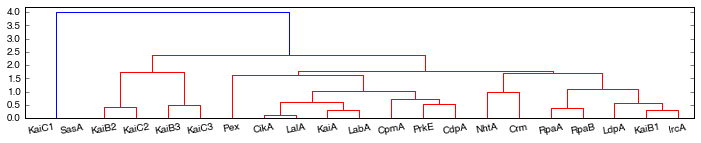

In [16]:
# Plot the dendrogram/clustering tree

plt.figure(figsize=(12,2))
row_dendr = dendrogram(row_clusters, labels=PCC7942)

In [21]:
sorter_drop = ['KaiC1','SasA','NhtA','RpaB','RpaA','IrcA','KaiB1','LdpA','KaiA','Pex','CpmA',
               'CdpA','LabA','LalA','CikA','PrkE','KaiB3','KaiC3','Crm','KaiB2','KaiC2']              

In [22]:
data1 = sort_df(data,sorter_drop)
data1.iloc[:,:-1].head()

,KaiC1,SasA,NhtA,RpaB,RpaA,IrcA,KaiB1,LdpA,KaiA,Pex,...,CdpA,LabA,LalA,CikA,PrkE,KaiB3,KaiC3,Crm,KaiB2,KaiC2
index,,,,,,,,,,,,,,,,,,,,,
KaiC1,1,1,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
SasA,1,1,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
NhtA,1,1,1.165740e-31,0.713915,0.713915,0.444023,0.207371,0.280164,0.298649,0.018186,...,0.100369,0.239016,0.413365,0.470016,0.004414,0.276507,0.404269,0.112391,0.997045,0.985410
RpaB,1,1,7.139148e-01,0.009346,0.036864,0.055036,0.055036,0.090862,0.046729,0.476636,...,0.214953,0.121495,0.149533,0.130841,0.317757,0.682243,0.682243,0.476636,0.859813,0.859813
RpaA,1,1,7.139148e-01,0.036864,0.009346,0.018692,0.055036,0.090862,0.108515,0.476636,...,0.396677,0.243510,0.291277,0.259605,0.545171,0.682243,0.682243,0.476636,0.859813,0.859813


In [23]:
sorter = sorter_drop

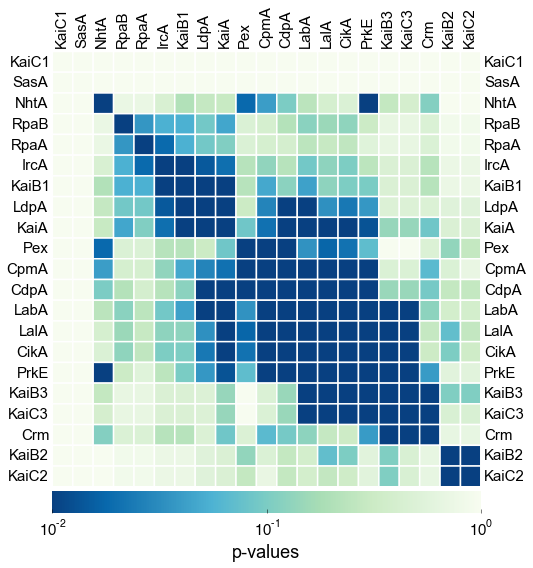

In [24]:
f, ax = plt.subplots(1,1, figsize=(7.5,8)) 

hfont = {'fontname':'Arial'}

ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False) 

xlim(0, len(sorter))
ylim(0, len(sorter))

plt.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="off", left="off", right="off", labelleft='on',
                labelright='on', labeltop="on")

ax.set_xticks(np.arange(len(sorter))+0.5, minor=False)
ax.set_yticks(np.arange(len(sorter))+0.5, minor=False)

labels = []

for ele in sorter:
    labels.append(ele[0].upper() + ele[1:])

ax.set_xticklabels(labels, fontsize=15, rotation=90, **hfont)
ax.set_yticklabels(labels, fontsize=15, rotation=0, **hfont)

heatmap = plt.pcolor(data1, cmap='GnBu_r',
                     norm=LogNorm(vmax=1, vmin=1e-2),
                     lw=1.5, edgecolors='w')

cbar = f.colorbar(heatmap, orientation='horizontal', pad=0.01, fraction=0.07)

cbar.ax.tick_params(labelsize=15) 
    
cbar.set_label('p-values', fontsize=18, **hfont)
cbar.outline.set_linewidth(0)

f.tight_layout()
ax.invert_yaxis()

#plt.savefig('Correlation_drop.png', dpi=600)

---
###Previous###

+ [Data Collection and Processing](1_KaiABC_BLAST_DataCollectionProcessing.ipynb)
+ [Impact of filtering on the number of hits](2_KaiABC_BLAST_BarChart.ipynb)
+ [Distribution of circadian clock protein](3_KaiABC_BLAST_Heatmap.ipynb)
+ [Length distribution of KaiA, KaiB, KaiC](4_KaiABC_BLAST_Scatterplot.ipynb)

---